<a href="https://colab.research.google.com/github/AlexandraLJones/FIRE-CloudComputing/blob/main/CharacterizingSevereDiscrepancies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FIRE 198 Written Report 
##Characterizing Discrepancies
###Rahul Joshi, Jack Larcome, Josh Smith, Michelle Badalov
###Edited by Dr. Jones 7-16-2020



#Introduction


> As researchers try to gather more knowledge about a certain topic, local ways of making a difference and finding data are desired. Citizen science is a perfect solution. It is a collaboration between scientists and the general public to collect data in a way that revolutionizes science. 


> Our assigned topic was to characterize the discrepancies between satellite and citizen scientist observations from teh GLOBE clouds project (Dodson et al., 2018). A discrepancy is a disagreement between two or more facts. We wanted to determine what the most severe discrepancies were in magnitude and in frequency of occurrence and also characterize the conditions associated with these discrepancies. A discrepancy is severe in magnitude when it is at a very high percentage. A discrepancy is severe in frequency when a discrepancy of any percentage occurrs significantly often in time. Using the 2017-2019 GLOBE Observations from the GLOBE clouds program, we visualized the distribution of discrepancy magnitude and frequency and determined what should be considered severe for all altitudes of cloud cover. Depending on their characteristics, height, and cloud cover in the atmosphere, clouds can influence the energy balance on the planet in different ways (nasa.gov). Following this, our goal was to determine if there were any conditions that were associated with the severities and also determined if the conditions associated with excellent agreement differed. 

>Characterzing the discrepancies will allow us to improve citizen science in order to gather mass data which will then greatly increase and imporve research on clouds and their characteristics. Clouds play a great role in weather patterns and with heating our planet (Werkmeister). By understanding the discrepancies we work towards our goal of predicing how clouds affect Earth's climate.


#Dependencies

We mostly relied on basic python data manupilation packages. We used pandas for data frames, numpy for using numpy arrays, and pyplot from matplotlib to visualize our data.

In [ ]:
import pandas as pd #this allows us to use/read in structures like Dataframes
import matplotlib.pyplot as plt #this is our plotting package
import numpy as np #this allows us to use np arrays

We must mount to Google Drive so that we can access the data

In [ ]:
from google.colab import drive #this module allows us to access files on google drive
drive.mount('/content/gdrive') #you will need to authorize access using your google account. Follow the instructions that appear below

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#Data
**Source:**
The data we used is collected by citizen scientists using the NASA Globe applications. For each row in a dataset, we have observations of cloud cover % for a location from citizen scientist (referred to as an observation) and a satellite (referred to as the GEO observation), as well as locational data (latitude and longitude) and the altitude. We combined the 2017, 2018 and 2019 datasets into a single pandas dataframe, and used that in this project. 



The code here gets the pickle files from the shared Google Drive for each year (2017, 2018, 2019) of cloud observations.

In [ ]:
CloudCover2017_df = pd.read_pickle("/content/gdrive/Shared drives/FIRE-CC/pkl files/2017GLOBEclouddata.pkl");# Reading the 2017 data
CloudCover2018_df = pd.read_pickle("/content/gdrive/Shared drives/FIRE-CC/pkl files/2018GLOBEclouddata.pkl");# Reading the 2018 data
CloudCover2019_df = pd.read_pickle("/content/gdrive/Shared drives/FIRE-CC/pkl files/2019GLOBEclouddata.pkl");# Reading the 2019 data

Here we are combining all three dataframes with the cloud observations we obtained earlier into one single data frame. 

In [ ]:
# Combining all data into a single dataframe
CloudCover_df = pd.concat([CloudCover2017_df, CloudCover2018_df, CloudCover2019_df], ignore_index=True);
pd.set_option('display.max_rows', 500)
# Displaying all columns present, for future reference.
print(CloudCover_df.columns)

Index(['Observation Latitude', 'Observation Longitude',
       'Measurement Date (UTC)', 'Measurement Time (UTC)', 'Total Cloud Cover',
       'High Cloud Cover', 'Mid Cloud Cover', 'Low Cloud Cover',
       'GEO Total Cloud Cover', 'GEO High Cloud Cover', 'GEO Mid Cloud Cover',
       'GEO Low Cloud Cover'],
      dtype='object')


**Selected data:**
While studying the data, we did not use the data in our dataset that was "incorrect" or could not be used. Some of the data we did not use are:
*   Cloud cover observations by citizen scientists that were categorized as "-99", indicating it was missing.

*   Cloud cover observations by citizen scientists categorized as "obscured", indicating the view of the observer was blocked.

*   GEO observations that had cloud cover % less than 0, or greater than 100, as the range of GEO data is described to be [0,100], and thus would be considered an error.


In order to easily understood numerically, the date and times were converted from strings into date times.

In [ ]:
#Convert dates which are currently string into datetimes so that they can be understood numerically/sequentially
CloudCover_df['Measurement Time (UTC)'] = pd.to_datetime(CloudCover_df['Measurement Time (UTC)'])
CloudCover_df['Measurement Time (UTC)'] = [time.time() for time in CloudCover_df['Measurement Time (UTC)']]


**Data limitations:**
A major limitation of the data is the citizen scientist observations. The cloud cover observations of the citizen scientists are stored by category. Each category indicates a range of possible cloud cover percentage values instead of an exact value. It was hard, therefore, to summarize all the discrepencies very accurately. Instead, we have a general idea of where the discrepencies lie, by taking the mid point of the range for each data point.

As citizen scientist observaions of cloud cover are stored as a category indicating a range of cloud cover %, we created a a dictionary mapping each possible category to its range. This will allow us to directly compare the citizen data to the satellite data, as the satellite data is given numerically.

In [ ]:
# Creating a key value store (dictionary) for each category to use
# to map a category to its range.
categories = {
    'none': {
        'min': 0,
        'max': 0,
        'mid': 0
    },
    'few': {
        'min': 0,
        'max': 10,
        'mid': 5
    },
    'isolated': {
        'min': 10,
        'max': 25,
        'mid': 17.5
    },
    'scattered': {
        'min': 25,
        'max': 50,
        'mid': 37.5
    },
    'broken': {
        'min': 50,
        'max': 90,
        'mid': 70
    },
    'overcast': {
        'min': 90,
        'max': 100,
        'mid': 95
    }
}

Now we will replace each of these caegorical words with a number so we can perform computations. FOr now we will choose the mid point of the corresponding range.

In [ ]:
for key in categories.keys():
  CloudCover_df = CloudCover_df.replace(to_replace = key, value = categories[key]['mid'])

Not all of the data in the dataframes are good for what we want to look for. For example, some of the reports contain -99 cloud cover, meaning there was no observation. Here we are filtering that out so it is not a contributer in the data. We also filtered out the category 'obscured' as cloud ovebservation was not possible. 

In [ ]:
# If cloud cover is -99 the data is missing, and should be filtered out.
# If cloud cover is of category "obscured", the view was blocked and the data point can be filtered out.
total_cloud_cover_df = CloudCover_df[(CloudCover_df['Total Cloud Cover']!='-99')&
                                     (CloudCover_df['Total Cloud Cover']!='obscured')]

high_cloud_cover_df = CloudCover_df[(CloudCover_df['High Cloud Cover']!='-99')&
                                    (CloudCover_df['High Cloud Cover']!=-99)&
                                     (CloudCover_df['Total Cloud Cover']!='obscured')]

mid_cloud_cover_df = CloudCover_df[(CloudCover_df['Mid Cloud Cover']!='-99')&
                                    (CloudCover_df['Mid Cloud Cover']!=-99)&
                                     (CloudCover_df['Total Cloud Cover']!='obscured')]

low_cloud_cover_df = CloudCover_df[(CloudCover_df['Low Cloud Cover']!='-99')&
                                    (CloudCover_df['Low Cloud Cover']!=-99)&
                                     (CloudCover_df['Total Cloud Cover']!='obscured')]

Although the specified observation range for GEO observations (made by satellites) was stated as [0, 100], there were some data points that were greater than 100, or less than 0. Similar to what we just did, we are going to filter out this data, so that it does not affect our results later on. 

In [ ]:
# Below, some data points in the GEO Data were found to be >100 or <0, even 
# though the range was said to be [0,100] in the readme file. These data points
# were filtered out for each data frame.
total_cloud_cover_df = total_cloud_cover_df[(total_cloud_cover_df['GEO Total Cloud Cover']<100)&
                                            (total_cloud_cover_df['GEO Total Cloud Cover']>0)]

high_cloud_cover_df = high_cloud_cover_df[(high_cloud_cover_df['GEO High Cloud Cover']<100)&
                                          (high_cloud_cover_df['GEO High Cloud Cover']>0)]

mid_cloud_cover_df = mid_cloud_cover_df[(mid_cloud_cover_df['GEO Mid Cloud Cover']<100)&
                                        (mid_cloud_cover_df['GEO Mid Cloud Cover']>0)]
                                        
low_cloud_cover_df = low_cloud_cover_df[(low_cloud_cover_df['GEO Low Cloud Cover']<100)&
                                        (low_cloud_cover_df['GEO Low Cloud Cover']>0)]

#Methods





##What is the joint distribution of the cloud coverage at each altitude?

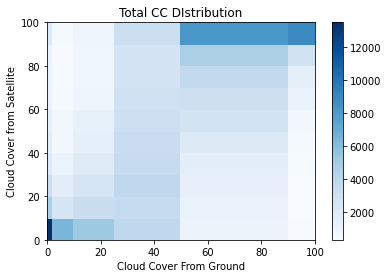

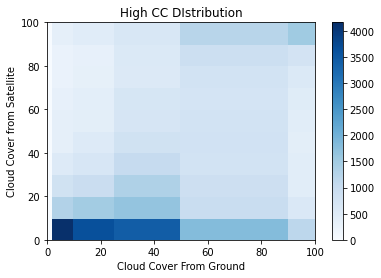

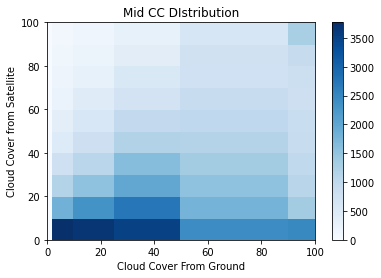

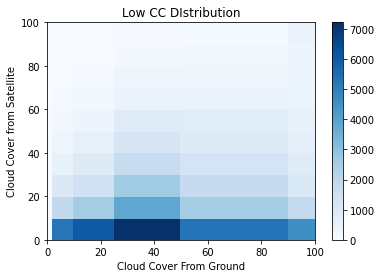

In [ ]:
use_bins=[[0,2,10,25,50,90,100],[0,10,20,30,40,50,60,70,80,90,100]]


#CLoud Cover
fig, axs = plt.subplots()
h=plt.hist2d(total_cloud_cover_df['Total Cloud Cover'], total_cloud_cover_df['GEO Total Cloud Cover'],bins=use_bins, cmap='Blues')
plt.xlabel('Cloud Cover From Ground')
plt.ylabel('Cloud Cover from Satellite')
plt.title('Total CC DIstribution')
plt.colorbar(h[3], ax=axs)

fig, axs = plt.subplots()
h=plt.hist2d(high_cloud_cover_df['High Cloud Cover'], high_cloud_cover_df['GEO High Cloud Cover'],bins=use_bins, cmap='Blues')
plt.xlabel('Cloud Cover From Ground')
plt.ylabel('Cloud Cover from Satellite')
plt.title('High CC DIstribution')
plt.colorbar(h[3], ax=axs)

fig, axs = plt.subplots()
h=plt.hist2d(mid_cloud_cover_df['Mid Cloud Cover'], mid_cloud_cover_df['GEO Mid Cloud Cover'],bins=use_bins, cmap='Blues')
plt.xlabel('Cloud Cover From Ground')
plt.ylabel('Cloud Cover from Satellite')
plt.title('Mid CC DIstribution')
plt.colorbar(h[3], ax=axs)

fig, axs = plt.subplots()
h=plt.hist2d(low_cloud_cover_df['Low Cloud Cover'], low_cloud_cover_df['GEO Low Cloud Cover'],bins=use_bins, cmap='Blues')
plt.xlabel('Cloud Cover From Ground')
plt.ylabel('Cloud Cover from Satellite')
plt.title('Low CC DIstribution')
plt.colorbar(h[3], ax=axs)


## Determine What is Considered a Severe Discrepency

To obtain the discrepencies, we used the 'categories' dictionary defined earlier to convert each citizen observation to a numeric value (mid of its range), and subtracted the GEO observation value from  it.

The difference between the two numbers for each data point is stored into an array that will later be used to plot the data on a graph. This process is done for Total, Low, Mid, and High cloud cover. 

Determning the discrepancy will output either a negative or positive number. This is a result of the calculation. The number itself is still accurate, however the sign gives us a message. **If the discrepancy is negative, we gather that the sattelite reported more cloud coverage than the ground observer. On the flip side, if the discrepancy is positive, the ground observer reported more cloud coverage than the satellite.**

In [ ]:
# Initializing the arrays to store the discrepencies.
total_cloud_cover_descrepencies = []
high_cloud_cover_descrepencies = []
mid_cloud_cover_descrepencies = []
low_cloud_cover_descrepencies = []

# Obtaining the total cloud cover discrepecies.
for index, row in total_cloud_cover_df.iterrows():
  # The statement below uses the dictionary 'cateogories' to convert the type
  # of cloud cover into an object that contains the 'high', 'low' and 'mid' of
  # its respective range. This has been done for all the altitude arrays.
  #total_cc = categories[row['Total Cloud Cover']]
  # Subtracting the mid of the citizen observation to the value of the GEO 
  # observation. This has been done for all the altitude arrays.
  #total_cloud_cover_descrepencies.append(total_cc['mid'] - row['GEO Total Cloud Cover'])
  total_cloud_cover_descrepencies.append(row['Total Cloud Cover'] - row['GEO Total Cloud Cover'])

# Obtaining the high cloud cover discrepecies.
for index, row in high_cloud_cover_df.iterrows():
 # high_cc = categories[row['High Cloud Cover']]
  high_cloud_cover_descrepencies.append(row['High Cloud Cover'] - row['GEO High Cloud Cover'])

# Obtaining the mid cloud cover discrepecies.
for index, row in mid_cloud_cover_df.iterrows():
  #mid_cc = categories[row['Mid Cloud Cover']]
  mid_cloud_cover_descrepencies.append(row['Mid Cloud Cover'] - row['GEO Mid Cloud Cover'])

# Obtaining the high cloud cover discrepecies.
for index, row in low_cloud_cover_df.iterrows():
  #low_cc = categories[row['Low Cloud Cover']]
  low_cloud_cover_descrepencies.append(row['Low Cloud Cover'] - row['GEO Low Cloud Cover'])

now let's add those discrepancies as columns in the dataframes for later use

In [ ]:
total_cloud_cover_df['discrepancy']=total_cloud_cover_descrepencies
high_cloud_cover_df['discrepancy']=high_cloud_cover_descrepencies
mid_cloud_cover_df['discrepancy']=mid_cloud_cover_descrepencies
low_cloud_cover_df['discrepancy']=low_cloud_cover_descrepencies

Now it is time to plot the discrepancies. On the x axis, we will plot the  discrepancy and the y axis  the fraction of observations in that discrepancy bin.  

This all is done by using packages imported from myplotlib. This is done for each level of cloud cover.

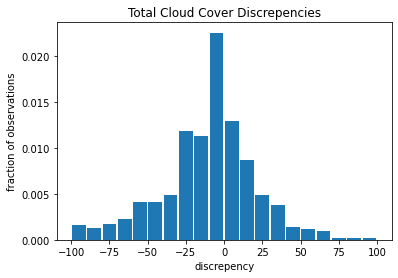

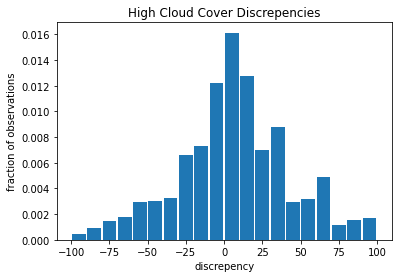

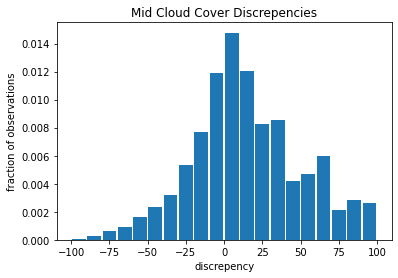

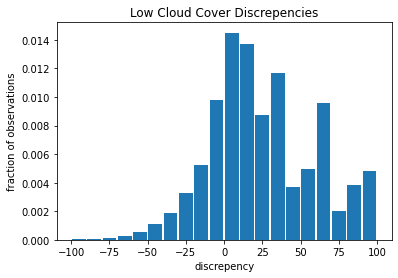

In [ ]:
plt.hist(total_cloud_cover_descrepencies,bins=20,range=(-100,100),rwidth=.9, density=True)
plt.title("Total Cloud Cover Discrepencies") # setting the title
plt.ylabel("fraction of observations") # setting y label
plt.xlabel("discrepency") # setting x label
plt.show()

plt.hist(high_cloud_cover_descrepencies,bins=20,range=(-100,100),rwidth=.9, density=True)
plt.title("High Cloud Cover Discrepencies") # setting the title
plt.ylabel("fraction of observations") # setting y label
plt.xlabel("discrepency") # setting x label
plt.show()

plt.hist(mid_cloud_cover_descrepencies,bins=20,range=(-100,100),rwidth=.9, density=True)
plt.title("Mid Cloud Cover Discrepencies") # setting the title
plt.ylabel("fraction of observations") # setting y label
plt.xlabel("discrepency") # setting x label
plt.show()

plt.hist(low_cloud_cover_descrepencies,bins=20,range=(-100,100),rwidth=.9, density=True)
plt.title("Low Cloud Cover Discrepencies") # setting the title
plt.ylabel("fraction of observations") # setting y label
plt.xlabel("discrepency") # setting x label
plt.show()

One interesting observation is that in the Total Cloud Cover, the most frequent discrepancy is in the -10-0 bin, while for each altitude, the peak is in the 0-10 bin. This implies a problem with place clouds in the correct altitude bin.

The Total Cloud Cover histogram appears to be skewed to the left, especially in the tails, inidicating that there seems to be a larger report of total cloud cover by the satellite data, as the majority of the discrepancies are negative.

High-Cloud Cover appears to be pretty symmetric.
On the other hand, the Low and mid Cloud Cover appears to be skewed to the right, indicating a larger report of low cloud cover by ground observers. Due to intervening cloud layers obstructing the lower clouds the satellite may underreport low and mid level clouds relative to the ground observer. However, it's surprising that the low and mid level clouds don't heavily bias the ground observers veiw of high clouds towards underreporting.

We will consider a discrepancy over 50 to be severe. We will now want to specifically look at any observations that have severe discrepancies and see if they share any common characteristics. This will allow us to find an explaination why severe discrepancies occur.


## Finding Common Characteristics with Severe Discrepancies

To find some common characteristics, we observe the difference in GEO data in data points with severe descrepencies and data points with low descrepencies, for each altitude.

To start we will filter the dataframes to just those with severe discrapncies or good agreement.As determined earlier, we considered discrepencies >=50% and <=-50% as severe. We also considered discrepencies >=-10% and <=10% as low discrepencies, or agreement.

In [ ]:
#good agreement
total_cc_agree=total_cloud_cover_df[(total_cloud_cover_df['discrepancy'] > -10.0) & (total_cloud_cover_df['discrepancy'] < 10.0)]
high_cc_agree=high_cloud_cover_df[(high_cloud_cover_df['discrepancy'] > -10.0) & (high_cloud_cover_df['discrepancy'] < 10.0)]
mid_cc_agree=mid_cloud_cover_df[(mid_cloud_cover_df['discrepancy'] > -10.0) & (mid_cloud_cover_df['discrepancy'] < 10.0)]
low_cc_agree=low_cloud_cover_df[(low_cloud_cover_df['discrepancy'] > -10.0) & (low_cloud_cover_df['discrepancy'] < 10.0)]

#severe positive discrepancy
total_cc_pos=total_cloud_cover_df[(total_cloud_cover_df['discrepancy'] > 50.0)]
high_cc_pos=high_cloud_cover_df[(high_cloud_cover_df['discrepancy'] > 50.0)]
mid_cc_pos=mid_cloud_cover_df[(mid_cloud_cover_df['discrepancy'] > 50.0)]
low_cc_pos=low_cloud_cover_df[(low_cloud_cover_df['discrepancy'] > 50.0)]

#severe negative discrepancy
total_cc_neg=total_cloud_cover_df[(total_cloud_cover_df['discrepancy'] < -50.0)]
high_cc_neg=high_cloud_cover_df[(high_cloud_cover_df['discrepancy'] < -50.0)]
mid_cc_neg=mid_cloud_cover_df[(mid_cloud_cover_df['discrepancy'] < -50.0)]
low_cc_neg=low_cloud_cover_df[(low_cloud_cover_df['discrepancy'] < -50.0)]

After obtaining the required data, we plotted a 2D histogram using the standard matplotlib library to show the intersection of GEO and ground observations for different ranges of cloud cover percentage for both severe and agreement data. This was done for all categories (low, mid, high, total) of cloud cover. 

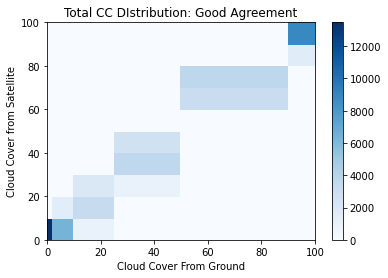

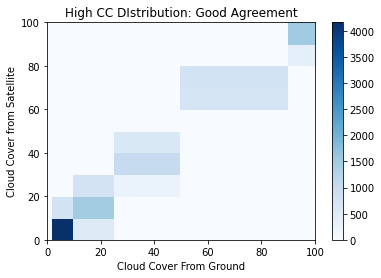

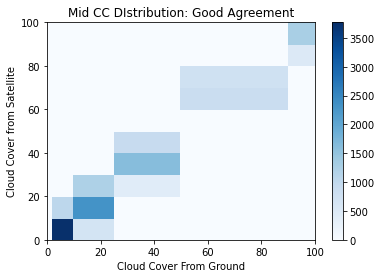

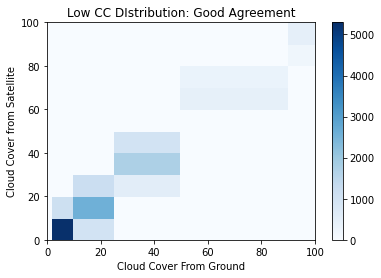

In [ ]:
#Good Agreement
fig, axs = plt.subplots()
h=plt.hist2d(total_cc_agree['Total Cloud Cover'], total_cc_agree['GEO Total Cloud Cover'],bins=use_bins, cmap='Blues')
plt.xlabel('Cloud Cover From Ground')
plt.ylabel('Cloud Cover from Satellite')
plt.title('Total CC DIstribution: Good Agreement')
plt.colorbar(h[3], ax=axs)

fig, axs = plt.subplots()
h=plt.hist2d(high_cc_agree['High Cloud Cover'], high_cc_agree['GEO High Cloud Cover'],bins=use_bins, cmap='Blues')
plt.xlabel('Cloud Cover From Ground')
plt.ylabel('Cloud Cover from Satellite')
plt.title('High CC DIstribution: Good Agreement')
plt.colorbar(h[3], ax=axs)

fig, axs = plt.subplots()
h=plt.hist2d(mid_cc_agree['Mid Cloud Cover'], mid_cc_agree['GEO Mid Cloud Cover'],bins=use_bins, cmap='Blues')
plt.xlabel('Cloud Cover From Ground')
plt.ylabel('Cloud Cover from Satellite')
plt.title('Mid CC DIstribution: Good Agreement')
plt.colorbar(h[3], ax=axs)

fig, axs = plt.subplots()
h=plt.hist2d(low_cc_agree['Low Cloud Cover'], low_cc_agree['GEO Low Cloud Cover'],bins=use_bins, cmap='Blues')
plt.xlabel('Cloud Cover From Ground')
plt.ylabel('Cloud Cover from Satellite')
plt.title('Low CC DIstribution: Good Agreement')
plt.colorbar(h[3], ax=axs)


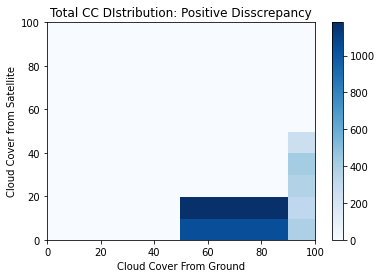

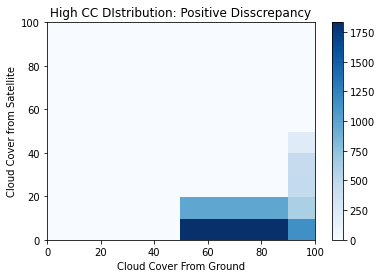

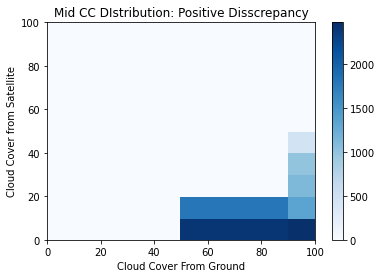

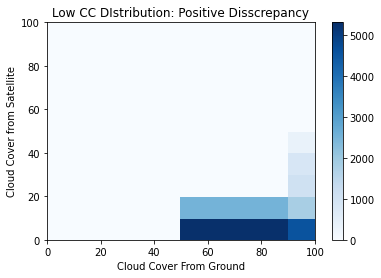

In [ ]:
#Positive Discrepancy
fig, axs = plt.subplots()
h=plt.hist2d(total_cc_pos['Total Cloud Cover'], total_cc_pos['GEO Total Cloud Cover'],bins=use_bins, cmap='Blues')
plt.xlabel('Cloud Cover From Ground')
plt.ylabel('Cloud Cover from Satellite')
plt.title('Total CC DIstribution: Positive Disscrepancy')
plt.colorbar(h[3], ax=axs)

fig, axs = plt.subplots()
h=plt.hist2d(high_cc_pos['High Cloud Cover'], high_cc_pos['GEO High Cloud Cover'],bins=use_bins, cmap='Blues')
plt.xlabel('Cloud Cover From Ground')
plt.ylabel('Cloud Cover from Satellite')
plt.title('High CC DIstribution: Positive Disscrepancy')
plt.colorbar(h[3], ax=axs)

fig, axs = plt.subplots()
h=plt.hist2d(mid_cc_pos['Mid Cloud Cover'], mid_cc_pos['GEO Mid Cloud Cover'],bins=use_bins, cmap='Blues')
plt.xlabel('Cloud Cover From Ground')
plt.ylabel('Cloud Cover from Satellite')
plt.title('Mid CC DIstribution: Positive Disscrepancy')
plt.colorbar(h[3], ax=axs)

fig, axs = plt.subplots()
h=plt.hist2d(low_cc_pos['Low Cloud Cover'], low_cc_pos['GEO Low Cloud Cover'],bins=use_bins, cmap='Blues')
plt.xlabel('Cloud Cover From Ground')
plt.ylabel('Cloud Cover from Satellite')
plt.title('Low CC DIstribution: Positive Disscrepancy')
plt.colorbar(h[3], ax=axs)

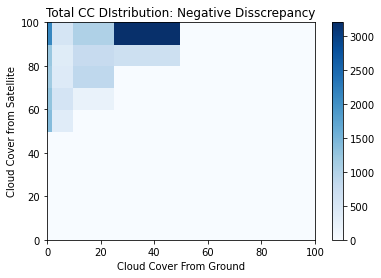

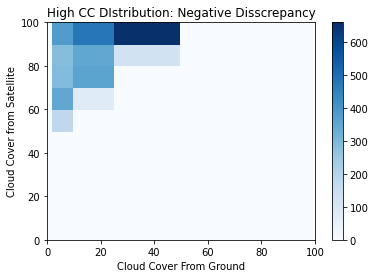

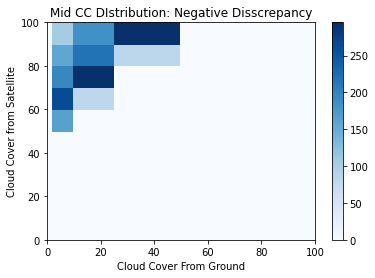

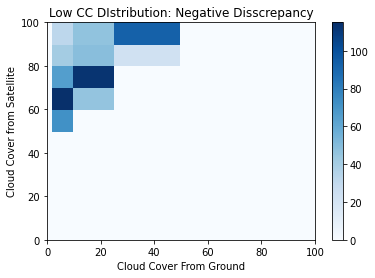

In [ ]:
#Negative Discrepancy
fig, axs = plt.subplots()
h=plt.hist2d(total_cc_neg['Total Cloud Cover'], total_cc_neg['GEO Total Cloud Cover'],bins=use_bins, cmap='Blues')
plt.xlabel('Cloud Cover From Ground')
plt.ylabel('Cloud Cover from Satellite')
plt.title('Total CC DIstribution: Negative Disscrepancy')
plt.colorbar(h[3], ax=axs)

fig, axs = plt.subplots()
h=plt.hist2d(high_cc_neg['High Cloud Cover'], high_cc_neg['GEO High Cloud Cover'],bins=use_bins, cmap='Blues')
plt.xlabel('Cloud Cover From Ground')
plt.ylabel('Cloud Cover from Satellite')
plt.title('High CC DIstribution: Negative Disscrepancy')
plt.colorbar(h[3], ax=axs)

fig, axs = plt.subplots()
h=plt.hist2d(mid_cc_neg['Mid Cloud Cover'], mid_cc_neg['GEO Mid Cloud Cover'],bins=use_bins, cmap='Blues')
plt.xlabel('Cloud Cover From Ground')
plt.ylabel('Cloud Cover from Satellite')
plt.title('Mid CC DIstribution: Negative Disscrepancy')
plt.colorbar(h[3], ax=axs)

fig, axs = plt.subplots()
h=plt.hist2d(low_cc_neg['Low Cloud Cover'], low_cc_neg['GEO Low Cloud Cover'],bins=use_bins, cmap='Blues')
plt.xlabel('Cloud Cover From Ground')
plt.ylabel('Cloud Cover from Satellite')
plt.title('Low CC DIstribution: Negative Disscrepancy')
plt.colorbar(h[3], ax=axs)

The joint distributions of cloud coverage are as expected for each category of agreement or discrapancy. But the question still remains if there are any predicatible factors that the observations within each class share. 

#Conclusions

The goal of this project was to categorize discrepencies between satellite and citizen observations, and investigate the conditions associated with them. Here, we have summarized our findings:

* For total cloud cover, the most severity in descrepancies can be found when the cloud cover of GEO data is high, usually >80, suggesting that citizens understate the percentage of total cloud cover relative to what the satellites report.

* For high cloud cover, the most discrepancies are found when GEO cloud cover % is low, but this is also where the highest agreement is found. More severe discrepencies are observed when the GEO cloud cover is low, rather than high. This same trend is more strongly observed in mid, and even more strongly in low cloud cover. 

Some possible explainations for discrepencies may be:
* Lower altitude clouds are more easy to spot by citizen observers from the ground, whereas for satellites, these could be obstructed by higher altitude clouds. Thus, the cloud cover % reported by the citizens could be higher than that reported by the satellite for lower altitude clouds.
* Satellites could also be making observations for certain locations from an angle, which could produce some discrepencies. 
* Some observers might not have good enough eye sight to estimate clouds very high up in the atmosphere.
* When cloud cover is not clear or totally covered, there is a lot of disagreement when it comes to broken clouds, as citizens have a harder time deciding what percentage of the sky is covered, leading to a discrepancy (Werkmeister, A.).

While we have theories, we do not have a clear answer for this trend. When continuing our work, we want to further explore these theories and continue to find commonalities between the severe discrepencies. 

#Bibliography
Dodson, J. B., et al. "Eclipse across America: Citizen Science Observations of the 21 August 2017 Total Solar Eclipse". *Journal of Applied Meteorology and Climatology*, 58(11), 2363-2385.

United States, NASA. “The Importance of Understanding Clouds.” The Importance of Understanding Clouds, NASA, pp. 1–6. https://www.nasa.gov/pdf/135641main_clouds_trifold21.pdf

Werkmeister, A., et al. "Comparing Satellite- To Ground-Based Automated and Manual Cloud Coverage Observations - A Case Study". *Atmospheric Measurement Teachniques*. vol. 8, 2015, pp. 2001-2015.
